In [1]:
# %% imports
import os, re, glob, json
import numpy as np
import pandas as pd

# будем стараться работать и с librosa, и с torchaudio
try:
    import librosa
except Exception:
    librosa = None

try:
    import soundfile as sf
except Exception:
    sf = None

# %% мел-спектрограмма (с запасным планом)
def load_audio(path, sr=48000):
    """Загружает аудио в моно, sr Гц."""
    if librosa is not None:
        y, _sr = librosa.load(path, sr=sr, mono=True)
        return y, sr
    if sf is not None:
        y, file_sr = sf.read(path, dtype="float32", always_2d=False)
        if y.ndim > 1:  # stereo -> mono
            y = y.mean(axis=1)
        # простая ресемплинг-замена при отсутствии librosa (не идеально, но рабоче)
        if file_sr != sr:
            # на всякий случай сделаем грубый ресемпл через интерполяцию
            x_old = np.linspace(0, 1, num=len(y), endpoint=False)
            x_new = np.linspace(0, 1, num=int(len(y) * sr / file_sr), endpoint=False)
            y = np.interp(x_new, x_old, y).astype(np.float32)
        return y, sr
    raise RuntimeError("Нужен хотя бы один из пакетов: librosa или soundfile")

def mel_spectrogram(y, sr, n_fft=1024, hop_length=256, n_mels=128, fmin=20, fmax=None):
    if librosa is None:
        # простая STFT + мел-фильтры вручную без librosa — опустим детали ради компактности
        # лучше установить librosa: pip install librosa
        raise RuntimeError("Для mel-спектрограммы лучше установить librosa: pip install librosa")
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax
    )
    # мощность -> dB стабилизация (можно оставить как есть — выбор ваш)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db

def l1_on_mels(path_a, path_b, sr=22050, **mel_kwargs):
    y1, _ = load_audio(path_a, sr=sr)
    y2, _ = load_audio(path_b, sr=sr)
    M1 = mel_spectrogram(y1, sr, **mel_kwargs)
    M2 = mel_spectrogram(y2, sr, **mel_kwargs)
    # выровняем по времени (колонкам)
    T = min(M1.shape[1], M2.shape[1])
    M1 = M1[:, :T]
    M2 = M2[:, :T]
    return np.mean(np.abs(M1 - M2))

# %% эвристика: выбрать src и tgt файл в папке
SRC_HINTS = re.compile(r"_0\.wav$", re.I)
TGT_HINTS = re.compile(r"_1\.wav$", re.I)

def pick_pair_in_folder(folder):
    """Ищет 2 аудиофайла: сначала по подсказкам в имени, иначе — первые два по алфавиту."""
    exts = ("*.wav", "*.flac", "*.mp3", "*.ogg")
    files = []
    for ext in exts:
        files += glob.glob(os.path.join(folder, ext))
    files = sorted(files)
    if len(files) < 2:
        return None, None

    # 1) хинты
    src_candidates = [f for f in files if SRC_HINTS.search(os.path.basename(f))]
    tgt_candidates = [f for f in files if TGT_HINTS.search(os.path.basename(f))]
    if src_candidates and tgt_candidates:
        # берём по одному
        return src_candidates[0], tgt_candidates[0]

    # 2) если только один с хинтом — разделим на src и всё остальное
    if src_candidates and len(files) >= 2:
        rest = [f for f in files if f != src_candidates[0]]
        return src_candidates[0], rest[0]
    if tgt_candidates and len(files) >= 2:
        rest = [f for f in files if f != tgt_candidates[0]]
        return rest[0], tgt_candidates[0]

    # 3) fallback — первые два файла
    return files[0], files[1]

# %% обойти папку outputs и собрать метрики
def collect_l1_table(outputs_root="outputs", sr=22050, mel_kwargs=None):
    mel_kwargs = mel_kwargs or dict(n_fft=1024, hop_length=256, n_mels=128, fmin=20, fmax=None)
    rows = []
    # ожидаем структуру: outputs/<exp_name>/<params_identifier>/
    exp_names = sorted([d for d in os.listdir(outputs_root) if os.path.isdir(os.path.join(outputs_root, d))])
    for exp in exp_names:
        exp_path = os.path.join(outputs_root, exp)
        param_dirs = sorted([d for d in os.listdir(exp_path) if os.path.isdir(os.path.join(exp_path, d))])
        for pid in param_dirs:
            folder = os.path.join(exp_path, pid)
            src, tgt = pick_pair_in_folder(folder)
            if not src or not tgt:
                print(f"[WARN] пропускаю (нет пары): {folder}")
                continue
            try:
                dist = l1_on_mels(src, tgt, sr=sr, **mel_kwargs)
            except Exception as e:
                print(f"[ERR] {folder}: {e}")
                continue
            rows.append({
                "exp_name": exp,
                "params_identifier": pid,
                "src_file": os.path.basename(src),
                "tgt_file": os.path.basename(tgt),
                "l1_mel": float(dist),
            })
    return pd.DataFrame(rows)

df = collect_l1_table("outputs")
df.head()


exp_name params_identifier                     src_file  \
0  all_blocks          alt_rock  output_20250806005055_0.wav   
1  all_blocks         dance_pop  output_20250806004904_0.wav   
2  all_blocks    dark_cinematic  output_20250806004941_0.wav   
3  all_blocks    dreamy_ambient  output_20250806004845_0.wav   
4  all_blocks     electro_house  output_20250806004923_0.wav   

                      tgt_file    l1_mel  
0  output_20250806005055_1.wav  4.596523  
1  output_20250806004904_1.wav  5.555578  
2  output_20250806004941_1.wav  6.188282  
3  output_20250806004845_1.wav  9.632608  
4  output_20250806004923_1.wav  5.240098

In [2]:
# %% агрегация и ранжировка
if df.empty:
    print("Данных не найдено. Проверьте структуру outputs/<exp>/<id> и наличие аудио.")
else:
    # рейтинг по среднему L1 для каждого конфига слоёв (exp_name)
    rank = (
        df.groupby("exp_name")["l1_mel"]
          .agg(["mean", "median", "std", "count"])
          .sort_values("mean", ascending=True)
          .reset_index()
    )
    display(rank)


exp_name      mean    median       std  count
0      all_blocks  5.854539  5.397838  1.632460     10
1     quarter_2_4  5.870905  4.997102  1.721411     10
2      first_half  5.967765  5.496737  1.986038     10
3      odd_blocks  6.111520  5.616270  1.563200     10
4       quarter_2  6.119724  5.600448  2.060768     10
5     quarter_2_3  6.178816  5.697168  2.049004     10
6      skip_three  6.255856  6.219865  1.884741     10
7     even_blocks  6.266922  5.829401  2.007001     10
8   sparse_middle  6.291954  6.358332  1.931246     10
9     second_half  6.443626  6.241450  1.716598     10
10    quarter_1_4  6.448586  6.062020  1.714962     10
11      quarter_4  6.517413  6.355826  1.733494     10
12      quarter_1  6.609864  6.148882  1.837071     10
13       sparse_4  6.651697  6.126059  1.788448     10
14       skip_two  6.667645  6.260542  1.785883     10
15      late_only  6.676613  6.251653  1.888272     10
16    quarter_1_3  6.695627  6.159562  1.873358     10
17       center_6  6.724618  6.189826  1.784448     10
18       sparse_6  6.727884  6.244345  1.875620     10
19       center_4  6.748149  6.272467  1.773152     10
20    middle_only  6.749070  6.274970  1.777581     10
21  head_and_tail  6.751317  6.243303  1.754639     10
22      quarter_3  6.759242  6.305165  1.742811     10
23     early_only  6.889515  6.458894  1.835366     10

In [ ]:
# Visualize a time-varying mask overlaid on a waveform, with colors.
# - If you set `audio_path` to an audio file, it will load and plot that.
# - Otherwise, it will generate a short synthetic demo waveform so you can see the overlay.
#
# You can tweak:
#   - colormap name (`cmap_name`)
#   - overlay alpha range (`overlay_alpha_min`, `overlay_alpha_max`)
#   - whether to also draw the mask as a line (`draw_mask_line`)

import numpy as np
import matplotlib.pyplot as plt

def beautyfull_waveform(l, audio_path):

    mask = np.asarray(l, dtype=float)
    mask = np.clip(mask, 0.0, 1.0)

    # Plot styling
    cmap_name = "plasma"           # colormap for the overlay
    overlay_alpha_min = 0.20       # minimum alpha of overlay
    overlay_alpha_max = 0.85       # maximum alpha of overlay
    draw_mask_line = True          # also draw mask as a line on top

    # ---- Prepare waveform ----
    sr = 48000
    if audio_path is None:
        # Synthetic demo waveform (replace with your own audio if needed)
        duration = 15.0
        t = np.linspace(0, duration, int(sr * duration), endpoint=False)
        # A simple synthetic mixture: two sines + amplitude modulation
        y = 0.6*np.sin(2*np.pi*220*t) + 0.4*np.sin(2*np.pi*440*t)
        y *= (0.5 + 0.5*np.sin(2*np.pi*0.5*t))  # slow AM for visual variety
    else:
        try:
            import soundfile as sf
            y, file_sr = sf.read(audio_path, dtype="float32", always_2d=False)
            if y.ndim > 1:
                y = y.mean(axis=1)
            # resample if needed
            if file_sr != sr:
                x_old = np.linspace(0, 1, num=len(y), endpoint=False)
                x_new = np.linspace(0, 1, num=int(len(y) * sr / file_sr), endpoint=False)
                y = np.interp(x_new, x_old, y).astype(np.float32)
            duration = len(y) / sr
            t = np.linspace(0, duration, len(y), endpoint=False)
        except Exception as e:
            # fallback to synthetic if loading fails
            duration = 6.0
            t = np.linspace(0, duration, int(sr * duration), endpoint=False)
            y = 0.6*np.sin(2*np.pi*220*t) + 0.4*np.sin(2*np.pi*440*t)
            y *= (0.5 + 0.5*np.sin(2*np.pi*0.5*t))

    # Normalize waveform for plotting
    if np.max(np.abs(y)) > 0:
        y_plot = y / np.max(np.abs(y))
    else:
        y_plot = y

    # ---- Resample mask to waveform length ----
    mask_resampled = np.interp(
        np.linspace(0, 1, len(y_plot), endpoint=False),
        np.linspace(0, 1, len(mask), endpoint=False),
        mask
    )

    # ---- Build colored overlay with alpha varying by mask ----
    # We'll render an image with shape (1, T) and map values to colors via colormap,
    # and set alpha based on mask strength so it "lights up" where mask is high.
    cmap = plt.get_cmap(cmap_name)
    overlay_colors = cmap(mask_resampled)  # RGBA, last channel will be replaced by custom alpha
    alpha = overlay_alpha_min + (overlay_alpha_max - overlay_alpha_min) * mask_resampled
    overlay_colors[..., -1] = alpha

    # For imshow we need a (H, W, 4) image. We'll use H=1 row and stretch over the axis extent.
    overlay_img = overlay_colors[np.newaxis, :, :]

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(12, 4))

    # Waveform
    ax.plot(t, y_plot, linewidth=1.0, color="black", label="waveform")

    # Colored overlay spanning the vertical axis
    ax.imshow(
        overlay_img,
        aspect="auto",
        extent=[t[0], t[-1], -1.05, 1.05],
        origin="lower"
    )

    # Optional: mask line on a secondary y-axis (0..1)
    if draw_mask_line:
        ax2 = ax.twinx()
        ax2.plot(t, mask_resampled, linewidth=1.2, color="tab:orange", alpha=0.9, label="mask")
        ax2.set_ylim(-0.02, 1.02)
        ax2.set_ylabel("mask")

    ax.set_xlim(t[0], t[-1])
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel("time (s)")
    ax.set_ylabel("amplitude")
    ax.set_title("Waveform with time-varying mask overlay")

    # Add a colorbar to show mapping
    # We'll create a standalone colorbar referencing the same colormap.
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=0, vmax=1)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.02)
    cbar.set_label("mask intensity")

    plt.tight_layout()
    plt.show()


In [21]:
gt = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
have = [0.5169, 0.0112, 0.9876, 1.0000, 0.5795, 0.0000, 0.0342, 0.0869, 1.0000,
        0.9499, 0.9723, 1.0000, 0.8608, 0.5610, 0.6719, 0.6237, 0.8321, 0.6708,
        0.1741, 0.4853, 0.6043, 0.0900, 0.4303, 0.5523, 0.7807, 0.1972, 0.0020,
        0.8926, 1.0000, 1.0000, 1.0000, 0.5387, 0.5182, 0.1715, 1.0000, 1.0000,
        0.9965, 0.1802, 0.0000, 1.0000, 1.0000, 1.0000, 0.6840, 0.4953, 0.0903,
        0.6583, 0.6349, 0.8175, 1.0000, 1.0000, 1.0000, 0.9526, 0.9173, 1.0000,
        1.0000, 0.3233, 0.8651, 0.8665, 0.3841, 0.5761, 0.5161, 0.5658, 0.0985,
        0.1205, 0.0000, 0.2140, 0.6504, 0.6124, 0.3891, 0.4008, 0.1643, 0.1059,
        0.3812, 0.3571, 0.2802, 0.2828, 0.0000, 0.5846, 0.4879, 0.0156, 0.0000,
        0.0000, 0.0000, 0.0688, 0.2579, 0.4906, 0.2441, 0.6373, 0.6850, 0.0022,
        0.3924, 0.3985, 0.7226, 0.3019, 0.3190, 0.0411, 0.3331, 0.2584, 0.5071,
        0.0000, 0.0000, 0.6091, 0.5961, 0.6207, 0.6811, 0.1854, 0.1496, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3912, 0.5051, 0.4875, 0.5884, 0.5891,
        0.2424, 0.1090, 0.0934, 0.0049, 0.4759, 0.5018, 0.4974, 0.0164, 0.0071,
        0.3819, 0.3826, 0.4819, 0.5732, 0.2086, 0.7962, 0.0000, 0.3704, 0.4428,
        0.9259, 0.4335, 0.4133, 0.2826, 0.0000, 0.4715, 0.1549, 0.2387, 0.4346,
        0.3282, 0.5033, 0.4932, 0.0000, 0.5093, 0.5641, 0.1157, 0.3738, 0.4877,
        0.5020, 0.4583, 0.4097, 0.3865, 0.3241, 0.8964, 1.0000, 0.9161]

In [59]:
WAV_PATH = '/home/mabondarenko_4/music_p2p/outputs_bad/center_4/synthwave/output_20250811005418_0.wav'

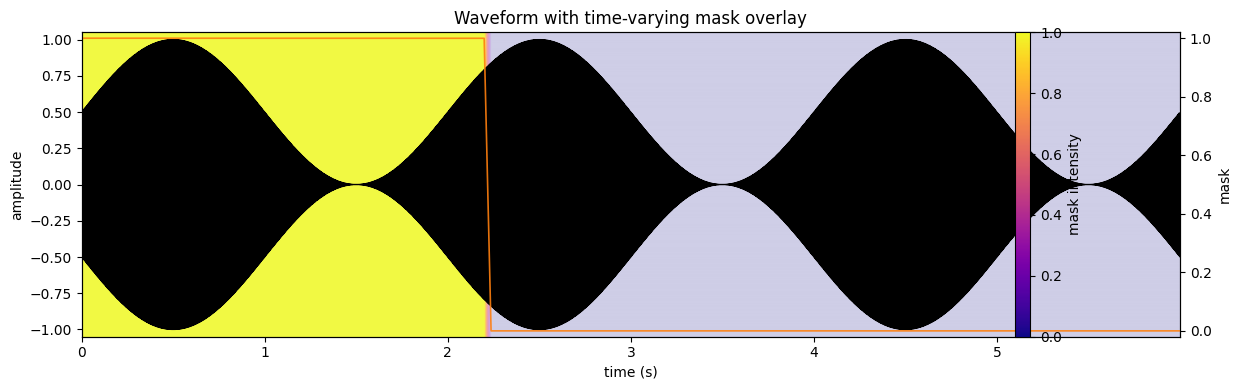

In [49]:
beautyfull_waveform(
    gt, WAV_PATH
)

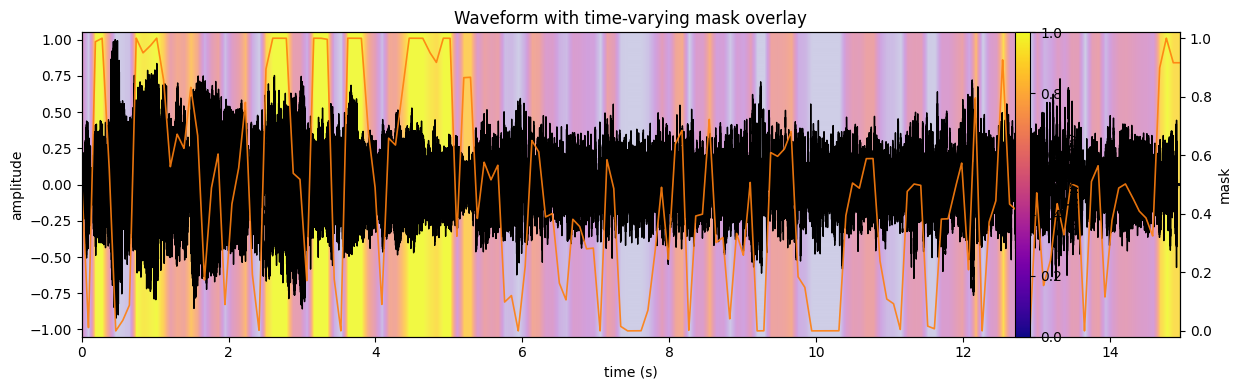

In [23]:
beautyfull_waveform(
    have,
    "/home/mabondarenko_4/music_p2p/outputs/center_4/psytrance/output_20250817184409_0.wav"
)

In [31]:
import torch
import torch.nn.functional as F

def gaussian_kernel_1d(kernel_size: int, sigma: float | None = None,
                       device=None, dtype=None) -> torch.Tensor:
    # делаем нечётным и не меньше 3
    k = max(3, int(kernel_size))
    if k % 2 == 0:
        k += 1
    if sigma is None:
        sigma = k / 3.0

    half = k // 2
    x = torch.arange(-half, half + 1, device=device, dtype=dtype)  # длина = k
    w = torch.exp(-0.5 * (x / float(sigma)) ** 2)
    w = w / (w.sum() + 1e-12)
    return w  # (k,)

def gaussian_blur_1d(input_tensor: torch.Tensor, kernel_size: int, sigma: float | None = None) -> torch.Tensor:
    """
    Сглаживает по времени последнюю ось T.
    Поддерживает входные формы:
      - (T,)
      - (B, T)
      - (B, C, T)  ← остаётся без изменений по каналам (C=1 тоже ок)
    """
    orig_dim = input_tensor.dim()
    x = input_tensor

    if orig_dim == 1:              # (T,)
        x = x.unsqueeze(0).unsqueeze(0)  # -> (1,1,T)
    elif orig_dim == 2:            # (B,T)
        x = x.unsqueeze(1)               # -> (B,1,T)
    elif orig_dim == 3:            # (B,C,T)
        pass
    else:
        raise ValueError(f"Unsupported input dim {orig_dim}; expected 1, 2, or 3.")

    # ядро на том же устройстве/типе
    k = gaussian_kernel_1d(kernel_size, sigma, device=x.device, dtype=x.dtype).view(1, 1, -1)

    pad = k.shape[-1] // 2
    # reflect-padding вручную, затем conv1d без padding, чтобы не «чернить» края
    x_pad = F.pad(x, (pad, pad), mode="reflect")
    blurred = F.conv1d(x_pad, k, stride=1, padding=0, groups=1)

    # вернуть исходную форму
    if orig_dim == 1:
        return blurred.squeeze(0).squeeze(0)      # (T,)
    elif orig_dim == 2:
        return blurred.squeeze(1)                 # (B,T)
    else:  # orig_dim == 3
        return blurred                             # (B,C,T)


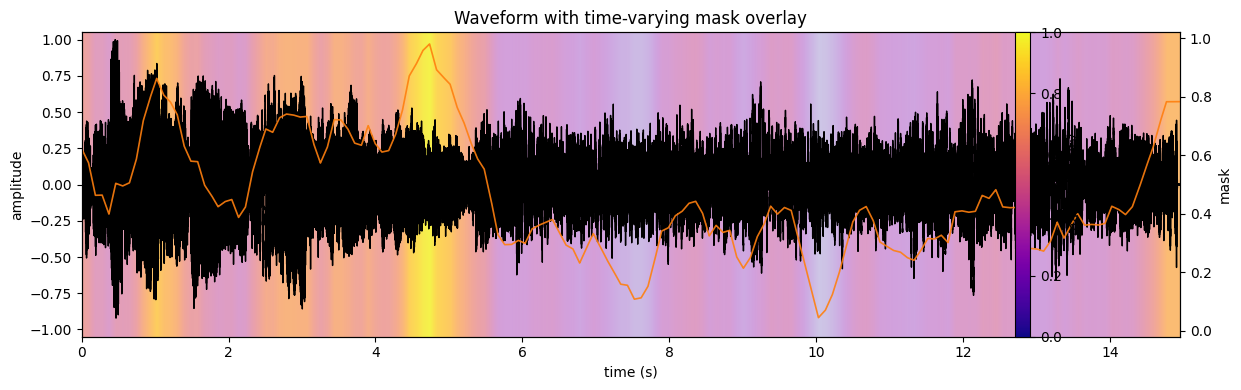

In [ ]:
beautyfull_waveform(
    gaussian_blur_1d(torch.tensor(have), 7, 5),
    "/home/mabondarenko_4/music_p2p/outputs/center_4/psytrance/output_20250817184409_0.wav"
)

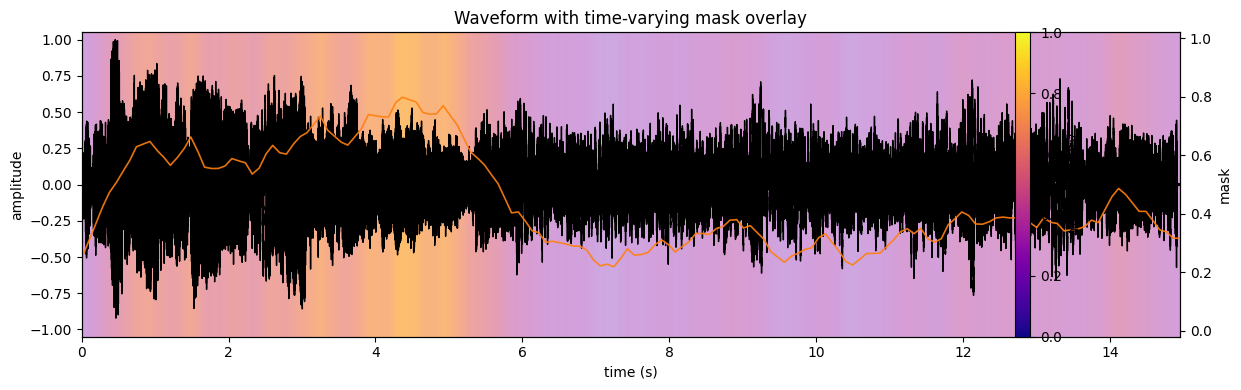

In [45]:
import torch.nn.functional as F

beautyfull_waveform(
    F.avg_pool1d(torch.tensor([have]), 17, padding=8, stride=1).squeeze(0),
    "/home/mabondarenko_4/music_p2p/outputs/center_4/psytrance/output_20250817184409_0.wav"
)

In [25]:
import numpy as np
from numpy.linalg import norm
norm(np.array(gt) - np.array(have))

np.float64(5.683265314939995)

In [2]:
# Minimal helper to preview a time mask on audio *inline* (no files saved).
# - Pass a 1D mask list/array of 0/1 (or 0..1) and a path to an audio file.
# - It will play: original, lyrics-only (mask), and non-lyrics-only (1-mask).
#
# Example:
#   preview_mask_on_audio(mask, "/mnt/data/your.wav")
#
# Notes:
# - Works with WAV/FLAC/OGG/MP3 (via soundfile).
# - Stereo is mixed to mono for clarity.
# - Mask is linearly interpolated to the waveform length.
# - Optional edge smoothing to avoid clicks (set smooth_ms=0 to disable).

import numpy as np
from IPython.display import display, Audio
import soundfile as sf
from scipy.signal import get_window, convolve

def _smooth_mask(mask, sr, smooth_ms: int):
    if smooth_ms <= 0:
        return mask
    win_len = max(3, int(sr * (smooth_ms / 1000.0)))
    if win_len % 2 == 0:
        win_len += 1
    w = get_window("hann", win_len, fftbins=False)
    w = w / np.sum(w)
    sm = convolve(mask, w, mode="same")
    return np.clip(sm, 0.0, 1.0)

def _resample_mask(mask_01, target_len):
    x_old = np.linspace(0, 1, num=len(mask_01), endpoint=False)
    x_new = np.linspace(0, 1, num=target_len, endpoint=False)
    return np.interp(x_new, x_old, mask_01)

def _normalize(y, peak=0.95):
    m = np.max(np.abs(y)) + 1e-12
    return (y / m * peak).astype(np.float32)

def preview_mask_on_audio(mask, audio_path, smooth_ms: int = 10, sr_override: int | None = None):
    # 1) Load audio
    y, sr = sf.read(audio_path, dtype="float32", always_2d=False)
    if y.ndim > 1:
        y = y.mean(axis=1)  # mono
    if sr_override is not None and sr_override > 0 and sr_override != sr:
        # Simple linear resample if needed
        x_old = np.linspace(0, 1, num=len(y), endpoint=False)
        x_new = np.linspace(0, 1, num=int(len(y) * sr_override / sr), endpoint=False)
        y = np.interp(x_new, x_old, y).astype(np.float32)
        sr = sr_override

    # 2) Prepare mask (0..1), resample & smooth
    mask = np.asarray(mask, dtype=float).ravel()
    mask = np.clip(mask, 0.0, 1.0)
    mask = _resample_mask(mask, len(y))
    mask = _smooth_mask(mask, sr, smooth_ms)

    # 3) Apply
    y_mask_lyrics = _normalize(y * mask)
    y_mask_non    = _normalize(y * (1.0 - mask))

    # 4) Play inline
    print("Original")
    display(Audio(_normalize(y), rate=sr))
    print("Lyrics only (mask)")
    display(Audio(y_mask_lyrics, rate=sr))
    print("Non-lyrics only (inverted mask)")
    display(Audio(y_mask_non, rate=sr))

In [14]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import Union, Sequence, Optional

def save_mel_with_mask(
    wav_path: str,
    mask: Union[np.ndarray, Sequence[int], Sequence[bool]],
    out_path: str = 'mel_with_mask.png',
    sr: Optional[int] = None,
    n_fft: int = 2048,
    hop_length: int = 512,
    n_mels: int = 128,
    fmin: float = 0.0,
    fmax: Optional[float] = None,
    dpi: int = 150,
    pad: float = 0.01,
):
    y, sr_eff = librosa.load(wav_path, sr=sr, mono=True)

    S = librosa.feature.melspectrogram(
        y=y, sr=sr_eff, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax
    )
    S_db = librosa.power_to_db(S, ref=np.max)

    T = S_db.shape[1]
    mask = np.asarray(mask).astype(bool).flatten()
    if mask.size != T:
        idx = np.round(np.linspace(0, mask.size - 1, T)).astype(int)
        mask = mask[idx]

    def _mask_runs(m: np.ndarray):
        if m.size == 0: 
            return []
        diff = np.diff(m.astype(int))
        starts = np.where(diff == 1)[0] + 1
        ends   = np.where(diff == -1)[0] + 1
        if m[0]:
            starts = np.r_[0, starts]
        if m[-1]:
            ends = np.r_[ends, m.size]
        return list(zip(starts, ends))

    spans = _mask_runs(mask)

    fig, ax = plt.subplots(figsize=(10, 2.2), dpi=dpi)
    img = librosa.display.specshow(
        S_db, sr=sr_eff, hop_length=hop_length,
        x_axis=None, y_axis=None, ax=ax, cmap='viridis'  # <- вот это
    )

    for (s, e) in spans:
        width = e - s
        rect = Rectangle(
            (s, 0), width, n_mels,
            fill=False, linewidth=5.0, edgecolor='red'
        )
        ax.add_patch(rect)

    ax.set_xlim(0, T)
    ax.set_ylim(0, n_mels)
    ax.axis('off')

    plt.savefig(out_path, bbox_inches="tight", pad_inches=pad)
    plt.close(fig)

In [69]:
WAV_PATH = '/home/mabondarenko_4/music_p2p/outputs_lyrics_dss1dse25scNone/quarter_2_3/dance_pop/output_20250831220555_2.wav'
mask = np.array([False]*100, dtype=bool)
mask[:62] = True
# mask[68:80] = True
# mask[90:] = True
preview_mask_on_audio(mask, WAV_PATH)

Original


Lyrics only (mask)


Non-lyrics only (inverted mask)


In [70]:
save_mel_with_mask(WAV_PATH, mask)